目的：
    選舉快到了，來看看主要的台北市長參選人FB的議題都是哪些東西

In [1]:
import gc
import numpy.random as rand
import matplotlib
import matplotlib.pyplot as plt
import jieba
import requests
import datetime
import re
import csv
import json
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
% matplotlib inline
#from https://gist.github.com/alexrudy/a7982903a2fb2ab0dde3
matplotlib.font_manager._rebuild()
#from https://medium.com/@wulala505/matplotlib-pyplot-%E5%9C%A8mac%E8%A8%AD%E5%AE%9A%E7%B9%81%E9%AB%94%E4%B8%AD%E6%96%87%E5%AD%97%E5%9E%8B-88f5b027a352
plt.rcParams['font.sans-serif'] = ['simhei']

In [2]:
def timestr_to_datetime(s:str):
    return datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:%S+%f')

def makefields(ls):
    if len(ls) == 0:
        return ''
    return 'fields=' + ','.join(ls) + '&'

In [3]:
PEOPLE = ['chung.siao.ping','DoctorKoWJ','YaoTurningTaipei','tingshouchung','annettelu.vp','sun.ta.chienn','professorofpower']
PEOPLE_NAME = ['鍾小平', '柯文哲', '姚立明', '丁守中', '呂秀蓮','孫大千','李錫錕']

In [4]:
TOKEN = 'EAACEdEose0cBAIBAZAH7MzsiE8TX93mJrfbVPK7nIaZAPeWoMPGTslZBumgQtYfCBt3p0udl4bPZAIiyvK4sA2jZANHJc4V790MtnmxySw3ij4ZCbW0XK5frUHfxaZBrHiIBDw2j94HOv6csazbxWSrv7PkrCsRlJnFo0E3EZAQJZAZBngsoiQGmjgJiwM3SUnO98ZD'
MSG_LIMIT_PAGE = 100 #最多100件
FIELDS = makefields(['about', 'posts.limit(%d)'%(MSG_LIMIT_PAGE)])
URL_TEMPLATE = 'https://graph.facebook.com/v2.12/%s?%saccess_token=%s'

算出開始時間

In [5]:
DATE_RANGE = 30
NOW = datetime.datetime.now()
TIME_START = NOW - datetime.timedelta(days=DATE_RANGE)

此區塊測試用

In [6]:
#URL_TEST = URL_TEMPLATE%(PEOPLE[0], FIELDS, TOKEN)

In [7]:
#DATA_TEST = json.loads(requests.get(URL_TEST).text)

合併文章 自動翻頁

In [8]:
#TODO: 自動翻頁
def parser(page:object, mode = 'posts', since:datetime = TIME_START) -> str:
    outstr = ''
    finished = False
    while(not finished):
        for i in range(len(page[mode]['data'])):
            try:
                if timestr_to_datetime(page[mode]['data'][i]['created_time']) <= since:
                    print('Reach time limit. Break now.')
                    finished = True
                    break
                else:
                    outstr += page[mode]['data'][i]['message']
            except KeyError as e:
                print('Current post has no key %s. Skipped.'%e)
                print(page[mode]['data'][i])
        try:
            page = dict()
            page[mode] = json.load(requests(page[mode]['paging']['next']))
        except Exception as e:
            print('%r'%e)
            print('Cannot access next page. Quit.')
            finished = True
        else:
            print('Current page: %s'%page[mode]['paging']['next'])
    gc.collect()
    return outstr

限定30天內的發文 開始爬文

In [9]:
test_datas_raw = []
test_urls = []
[test_urls.append(URL_TEMPLATE%(it, FIELDS, TOKEN)) for it in PEOPLE if True]
[test_datas_raw.append(parser(json.loads(requests.get(it).text))) for it in test_urls if True]

Current post has no key 'message'. Skipped.
{'created_time': '2018-03-29T04:05:32+0000', 'story': '鍾小平 updated their cover photo.', 'id': '154477784651665_1321811324584966'}
Current post has no key 'message'. Skipped.
{'created_time': '2018-03-20T07:06:33+0000', 'story': '鍾小平 updated their cover photo.', 'id': '154477784651665_1314211372011628'}
Reach time limit. Break now.
KeyError('posts',)
Cannot access next page. Quit.
Reach time limit. Break now.
KeyError('posts',)
Cannot access next page. Quit.
Current post has no key 'message'. Skipped.
{'created_time': '2018-04-05T13:42:05+0000', 'story': '姚文智翻台北 updated their cover photo.', 'id': '1380211668909443_1974484869482117'}
Current post has no key 'message'. Skipped.
{'created_time': '2018-03-17T03:06:23+0000', 'story': '姚文智翻台北 was live.', 'id': '1380211668909443_1965575360373068'}
Current post has no key 'message'. Skipped.
{'created_time': '2018-03-17T02:50:04+0000', 'story': '姚文智翻台北 was live.', 'id': '1380211668909443_1965565100374

[None, None, None, None, None, None, None]

**初始化jieba**

In [10]:
def csv_read(fname:str) -> list:
    out = list()
    with open(fname, 'r', encoding='utf-8') as f:
        rd = csv.reader(f)
        for it in rd:
            out += it
    return out

In [11]:
customwords = csv_read('custom_words.csv')
[jieba.add_word(it) for it in customwords if True]
stopwords = ['我', '對', '\n','xd', '的', '是', '在', '最', '很', '都', '無疑', '也', '了', '你', '有']
stopwords_file = csv_read('stop_words.csv') #詞庫不能有空白QQ
[stopwords.append(it) for it in stopwords_file if True]
print(stopwords)
puncs = '\\!\\?！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.。'

Building prefix dict from the default dictionary ...
Loading model from cache D:\ANDY\Appdata\Local\Temp\jieba.cache
Loading model cost 0.894 seconds.
Prefix dict has been built succesfully.


['我', '對', '\n', 'xd', '的', '是', '在', '最', '很', '都', '無疑', '也', '了', '你', '有', 'dummy', '全台', '一個', '一些', '一切', '一來', '二來', '一向', '一同', '一堆', '一場', '一天', '一套', '一定', '三不五時', '多', '上午', '下午', '一件', '一位', '偶爾', '一份', '一起', '一再', '一切都是', '能', '也能', '一下', '搭公車', '搭捷運', '一事', '一二', '一二三', '一仗', '一併', '一億', '一具', '一刀', '一刻', '一剪', '一區', '一周', '一圈', '一大堆', '一大步', '一大半', '一尾', '一州', '一句話', '一小', '一席話', '一句話', '一句', '一家人', '一家', '一年一度', '一年', '一度', '一座', '一大', '一手', '一拖', '再拖', '一招', '一台', '第一', '第二', '一方', '一旁的', '一堂課', '一堂', '一封信', '一方面', '方面', '一整天', '一日', '今天一早', '一路', '一部分', '的', '之', '一朵', '三十九']


切詞 清除標點

In [12]:
def clean(context:str) -> str:
    #context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",context)
    context = re.sub(puncs, '', context)
    context = re.sub('[【】╮╯▽╰╭★→「」]+','',context)
    context = re.sub('[！，❤。～《》：（）()【】「」？”“；：、]+','',context)
    context = re.sub('\d','',context)
    context = re.sub('[\-_~]','',context)
    context = re.sub('[0-9a-zA-Z]{1,}','', context)
    print(context)
    return context

def jieba_cut(S):
    S = clean(S)
    S = S.split(',')
    out = ''
    for j in S:
        lst = jieba.cut(j)
        lst_filtered = []
        for it in lst:
            if it not in stopwords:
                lst_filtered.append(it)
            else: 
                #print(it)
                pass
        out += ' '.join(lst_filtered)
    return out + ' '

把切詞分開進行 方便修改詞庫

In [13]:
test_datas = []
for it in test_datas_raw:
    test_datas.append(jieba_cut(it))

鍾小平當選市長後立刻恢復元敬老津貼

小平曾當面給柯文哲諫言要求恢復重陽敬老金但柯文哲卻說我現在發重陽敬老津貼的話網路族不投我了❗️

就如同郝龍斌市長所說的重陽敬老金不只是對長者的敬意謝意更重要是透過敬老金要求里長里幹事發放到戶傾聽基層聲音的機會這是北市府接地氣的做法之一億元的預算台北市政府絕對出得起也不會造成財政的負擔
小平當選市長後立刻恢復元敬老津貼讓里長能夠照顧傾聽關懷長者還給長者尊嚴❗️
#國民黨台北市長初選
#電話民調唯一支持鍾小平❗️
#支持小平粉絲團請按個讚👍 ://../../全台最好笑的笑話⁉️

不是綠與藍的惡鬥而是綠對白的依賴❗
 
洪耀福身為執政黨秘書長沒幫施政不力想解方
整天只為選舉說三道四
還公然要求『無黨籍』柯文哲認清目標打倒『國民黨』

在在證明民進黨對柯的依賴+對國民黨的畏懼❗

呼籲藍營選民應該要知道....
他們所害怕的國民黨並非鄭弘儀姚立明所支持的丁守中

而是敢說敢拼‼️誓言與不公不義正面對抗的🌟鍾小平🌟
　
🖋️新聞連結
與柯文哲關係洪耀福綠現階段最重要敵人還是國民黨
://.////…

民進黨北市禮讓柯姚立明我們都挺丁守中
://../.?=
　
#國民黨台北市長初選
#請唯一支持鍾小平🌟鍾小平浴血奮戰力抗獨裁柯🌟
　
小平的參選到底的決心不容小看
即使是假日也要拚到底
　
早上站動物園小時下午站花市小時晚上站吉普車喊話
　
中國國民黨 新站神由蔣改鍾💪💪💪
這一切皆為台北市民的美好未來而努力
　
#國民黨台北市長初選
#電話民調唯一支持鍾小平❗️
#支持小平粉絲團請按個讚👍 ://../../🏀中華民國三分球紀錄保持人鍾小平
不要說你不知道❗️
#國民黨台北市長初選
#電話民調唯一支持鍾小平❗️
#支持小平粉絲團請按個讚👍 ://../../民進黨選舉人選內鬥不斷蔡英文根本被新潮流綁架
將陳菊召回中央當秘書長硬塞蘇貞昌參選新北市長
　
此舉根本是地溝油炸回鍋肉從頭黑到底‼️
凸顯民進黨衰敗無新生代❗大老戀權❗
　
而小平身為✨國民黨不老鮮肉✨
會堅持初選參選到底而且自信會獲得提名❗

小平深信唯有小平能擺平柯
希望親愛的台北市朋友們能支持對的選擇
　
#不畏惡鬥平定一切
#黑夜降臨仍有小平
#國民黨台北市長初選
#請唯一支持鍾小平

🖋️新聞網址備戰新北 藍侯友宜領先但不掉以輕心
://...///.中華民國三分球

寧夏夜市拜票 
#丁守中拼台北驕傲管中閔的案子教育部拖了三個月還沒有結果最近才要成立專案審查小組一拖再拖政治介入假藉名目只為了卡管

但葉俊榮到浙江大學光華法學院兼課的案子教育部連查都沒有查葉俊榮過去兼職的日期還是台大上課期間教育部卻什麼話都不敢說完全是兩套標準管中閔是台大自治選出的校長被卡竟然這麼嚴格請問蔡英文葉俊榮還是內閣政務官妳竟雙重標準至此荒謬的政治鬧劇還是要演多久

#丁守中 #拚台北驕傲 
#卡管卡到天荒地老 #自己人真好 
#台北市 #電話民調 #唯一支持
#台大 #教育部 #台大校長 #管中閔 #校園自治 
#內政部 #葉俊榮南京復興站拜票

#徐巧芯
#王正德直播中歡迎大家一起來聊聊大巨蛋該何去何從柯上任三年多卻始終不給方向放這個大巨蛋浪費擺爛

丁守中
王鴻薇今天去攝影棚拍攝黨部初選要求的五分鐘政見演説拍攝過程一切順利感謝這麼多好朋友的幫忙沒有大家的協助不可能這麼快就完成這項任務公開選舉帳目 柯文哲只會裝傻賣乖轉移焦點

今天與郝副主席參加台北市前社會局長王浩兄的活動媒體問我對於柯選舉帳目不清的問題我認為柯是出了狀況很會裝傻賣乖轉移焦點的政治人物選舉帳目本來就應該清清楚楚這是一個身為政治人物基本該遵守的法律規範柯被人質疑竟然多筆五百萬元的單據只是簡單文具店買來的收據自填報帳簡直不可思議柯別轉移焦點先説清楚講明白

不論是政治獻金法或是陽光法案都是我丁守中在立委任內全力推動的法案我這麼多次選舉向來清清楚楚所有帳目也完全清楚申報這是本來就應該做的事情賴清德拚大位
蔡英文請鬼拿藥單

蔡英文政府不拚經濟拚權力鬥爭賴清德就是最明顯指標面臨經濟低迷不振人民低薪窮忙賴不把重點放在拚經濟拚提升台灣競爭力卻整天把腦筋放在花五百億改硬幣紙幣頭像以及花千億搞遷都這類議題上讓人想不透嗎

請問花這麼多錢改個紙幣銅板頭像除了讓某些人意識形態上爽而己對台灣民生經濟對你我人民荷包加薪有何幫助

遷都勞師動衆奔波兩地那廂龐大修建政府辦公室經費台北這邊則放空會增加政府效率

更糟糕的是我們以外貿立國理應與周邊國家搞好關係外交與兩岸關係同等重要才能努力拚好經濟經濟這麼差賴清德不拚經濟卻整天以台獨工作者自居你以為他真有心做好中華民國行政院長

説穿了賴清德一切跳脫常理的主張事實上都在算計他算準了台灣經濟差造成蔡英文民調不佳他才不會儍到去幫蔡英文拚經濟賴清德現在一切做的都是在為他自己

課外篇九十七集沒有人懂你

臉書朋友很多卻常常感到孤獨醒醒吧你沒有朋友因為你只想到你自己

#知音有幾人
#別把朋友當作情緒的垃圾桶錕踹共卡管卡到葉部長錕踹共三問柯錕踹共士林夜市水果事件政二代在職潛水課外篇九十六集歹路母湯行

辨別是非對錯的能力需要從小教育而不是當你歲成年的那一個瞬間就什麼都懂了

#我的小孩很乖一定都是別人帶壞
#養小孩不是養神豬

複習▶神豬的
://./第三季四十五集呷飽沒的大道理

蝦咪平常在家阿嬤問你的呷飽沒居然隱含了政治中最重要的建立共識快來看看錕怎麼說

#共識的
#問候人際學
#複習課外篇九十五集搶救傳產大作戰

台灣有許多傳產的隱形冠軍揚名國際但卻面臨接班問題要怎樣才能像美國石油大王洛克菲勒一樣富過七代錕傳授交棒心法

#老師傅的
#傳賢不傳子
#打破技職歧視錕之看圖猜成語你猜到了嗎😆

#掃墓小心火燭
#緬懷先人課外篇九十四集守護國家未來

終止兒童受虐問題就從你我開始做起

#不要再有下一個受虐兒祝福各位兒童節快樂還記得兒時的夢想嗎

#莫忘初衷
#有奇怪的東西混進來啦/感謝祭照片上線囉快呼叫親朋好友來認領吧 <
相簿開放到/時間到就會關閉囉第三季四十四集就決定是你了

如果你是面試官你會用什麼方式找出真正的人才

#恨的北高連線泛在野力量

松機遷移不只是台北市的事更需要跨縣市的合作促進區域平衡發展本次直播我與我的學生吳益政議員對談吳議員以無黨籍參選高雄市長做事誠懇認真深耕高雄十六年對於市政相當熟稔能夠有這樣的學生與我北高連線共同為台灣未來打拼我很驕傲

#泛在野力量大串連
#真正的正義溫暖錕踹共漲價誠痛苦幹話更可怕課外篇九十三集厭世代的人生

我們可以討厭世界但是不要討厭自己

#大人學第三季四十三集等價交換

情侶分手朋友反目生意談不攏人際關係決裂的原因其實比你想像的還簡單

#大人學鮑甘是一個基層公務員每天除了要面對主管交辦做不完的業務還要面對民代的奪命連環每天加班換看得到吃不到的補休早已是家常便飯……

#公務員不適用勞基法所以可以無限爆肝
#政府是全台最狠慣老闆
#許多公務員真的跟你想的不一樣
#佛系公僕台灣真的是寶島種什麼都好吃

#感謝彰化縣農會
#溪州無花果
#有機錕踹共血汗民代助理的悲歌錕踹共支持警察全面籌組工會錕踹共有時間辯論沒時間遷松機錕政見第一波松機特區

#下一站幸福
#老中青世代合作要客訴直播中


TF-IDF

In [14]:
vectorizer = TfidfVectorizer()
data_mat = vectorizer.fit_transform(test_datas)

印出矩陣，忽略 value = 0的部分
並輸出成可繪圖的矩陣

In [15]:
data_name = vectorizer.get_feature_names()
data_printable = []
print(data_mat.shape)
for i in range(data_mat.shape[0]):
    print('------in person [%s]---------'%(PEOPLE_NAME[i]))
    cnt = 0
    data_printable.append(list())
    data_printable[i].append(list())
    data_printable[i].append(list())
    for j in range(data_mat.shape[1]):
        if data_mat[i,j] == 0.0:
            pass
        else:
            print('%s\t\t%f'%(data_name[j], data_mat[i,j]))
            data_printable[i][0].append(data_name[j])
            data_printable[i][1].append(data_mat[i,j])
            cnt += 1
        if cnt >= 10: break
data_mat.toarray()
data_printable

(7, 8308)
------in person [鍾小平]---------
一員		0.008278
一模一樣		0.008278
一樣		0.003932
一步		0.010199
一生		0.016556
一直		0.005099
一萬		0.006871
丁丁		0.016556
丁守中		0.041115
三分球		0.049668
------in person [柯文哲]---------
一樣		0.010982
一次		0.028484
一次性		0.011560
一步		0.014242
一步步		0.009596
一段票		0.011560
一班		0.011560
一直		0.028484
一科		0.011560
一站		0.008202
------in person [姚立明]---------
一室		0.011382
一本		0.011382
一根		0.011382
一樣		0.005407
一次		0.007012
一片綠		0.011382
一發		0.011382
一直		0.007012
一票		0.018897
一貫主張		0.011382
------in person [丁守中]---------
一拖再拖		0.010927
一旦		0.009070
一月		0.010927
一樣		0.015572
一次		0.020194
一步		0.006731
一潭死水		0.010927
一絲		0.010927
一萬		0.009070
一面倒		0.021854
------in person [呂秀蓮]---------
一百位		0.053853
一群		0.044703
七星山		0.215413
三位		0.044703
不成		0.038210
不是		0.022568
世紀		0.053853
中午		0.038210
中原		0.107706
中山		0.029060
------in person [孫大千]---------
一任		0.004484
一封		0.004484
一席		0.004484
一戰		0.013451
一所		0.004484
一把		0.026902
一文不值		0.004484
一旦		0.018609
一樣		0.017038
一機		0.004484
-----

[[['一員', '一模一樣', '一樣', '一步', '一生', '一直', '一萬', '丁丁', '丁守中', '三分球'],
  [0.008278048705663519,
   0.008278048705663519,
   0.003932217345198243,
   0.010198877253925643,
   0.016556097411327037,
   0.0050994386269628215,
   0.006871491338704265,
   0.016556097411327037,
   0.041114661034391715,
   0.049668292233981115]],
 [['一樣', '一次', '一次性', '一步', '一步步', '一段票', '一班', '一直', '一科', '一站'],
  [0.01098209434614223,
   0.02848393727882522,
   0.011559675357031172,
   0.01424196863941261,
   0.009595523283129319,
   0.011559675357031172,
   0.011559675357031172,
   0.02848393727882522,
   0.011559675357031172,
   0.008201935208764579]],
 [['一室', '一本', '一根', '一樣', '一次', '一片綠', '一發', '一直', '一票', '一貫主張'],
  [0.011382483028060872,
   0.011382483028060872,
   0.011382483028060872,
   0.005406877729982868,
   0.0070118304068845,
   0.011382483028060872,
   0.011382483028060872,
   0.0070118304068845,
   0.018896876865862642,
   0.011382483028060872]],
 [['一拖再拖', '一旦', '一月', '一樣', '一次', '一步', '一潭死水', 

https://morvanzhou.github.io/tutorials/data-manipulation/plt/4-1-subpot1/
多合一顯示

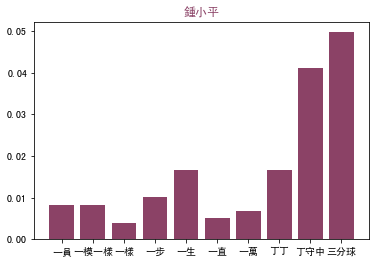

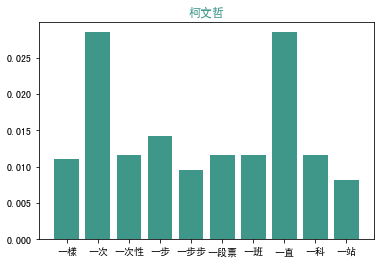

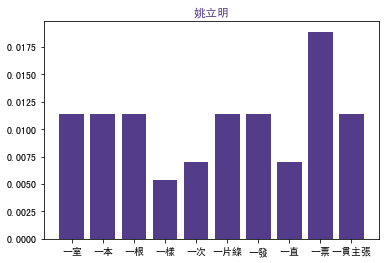

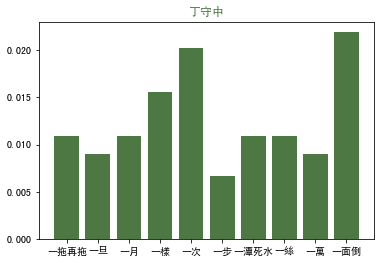

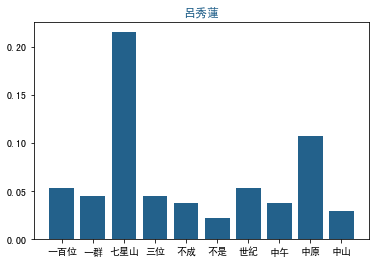

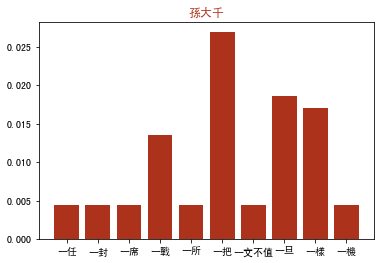

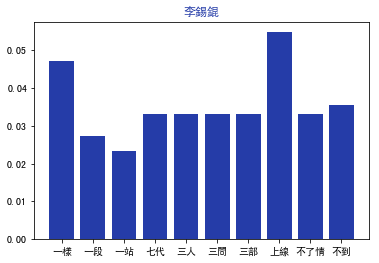

In [16]:
plt.figure()
for i in range(len(PEOPLE)):
    color = [tuple(row) for row in rand.random_sample((1,3)) * 0.75][0]
    plt.bar(data_printable[i][0], data_printable[i][1], color=color)
    plt.title(PEOPLE_NAME[i], color=color)
    plt.show()